In [1]:

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-paper")
# plt.style.available

random_seed = 0

In [6]:
num_seed = 20 # num of generated robot created by different prompt
num_joint_axis = 3 # x,y,z
num_joint_len = 10 # different joint created by scaling the limb
num_joint_name = num_seed*num_joint_len
# variation: base_name-upper_joint_axis-upper_name_upper_len-lower_joint_axis-lower_name_lower_len
search_space_shape = np.array([num_seed,num_joint_axis,num_joint_name,num_joint_axis,num_joint_name],dtype=np.int32)
print(f"variations:{search_space_shape}")
num_search_space = np.prod(search_space_shape)
print(f"total num of possible solution = {num_search_space}")

search_space_ids = np.meshgrid(*[np.arange(variation) for variation in search_space_shape],indexing="ij")

def closest_factors(number):
    """
    Finds the two factors of a given number that are as close to each other as possible.
    Args:
        number: The target number
    Returns:
        A tuple containing the two closest factors, or None if the number is 1 or less.
    """
    if number <= 1:
        return None
    candidate = int(np.sqrt(number))
    while candidate>0:
        if number % candidate == 0:
            return candidate, number // candidate
        candidate-=1
    return None

search_space_2d_shape =  closest_factors(num_search_space)
print(f"search space 2d shape:{search_space_2d_shape}")

variations:[ 20   3 200   3 200]
total num of possible solution = 7200000
search space 2d shape:(2500, 2880)


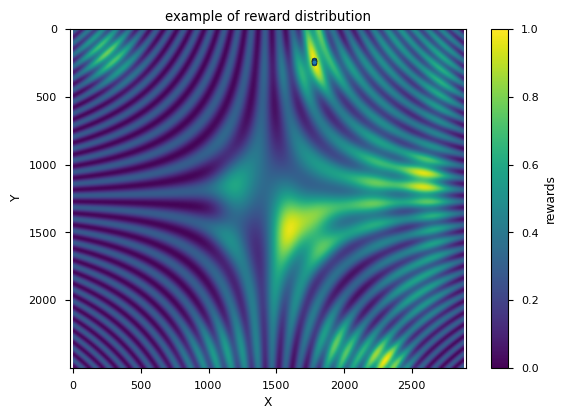

In [82]:
from scipy.stats import multivariate_normal
import cv2
np.random.seed(random_seed) # set random seed for repeatability
num_gaussian = 20
means = np.random.uniform(low=-3,high=3,size=num_gaussian*2).reshape(num_gaussian,2)
covs = np.random.uniform(low=0,high=0.5,size=num_gaussian*2).reshape(num_gaussian,2)

# num_gaussian=3
# means = np.array([[-2,-2],[-1,-1],[0,0]])
# covs = np.array([[1,1],[1,1],[1,1]])*0.1

normals = [multivariate_normal(mean=mean, cov=np.diag(cov)) for mean, cov in zip(means,covs)]



# covs = np.random.uniform(low=1,high=3,size=num_gaussian*4).reshape(num_gaussian,2,2)
# normals = [multivariate_normal(mean=mean, cov=cov.dot(cov.T)) for mean, cov in zip(means,covs)]

# Create a grid of coordinates
x, y = np.meshgrid(*[np.linspace(-3,3,num=200) for x in search_space_2d_shape],indexing="ij")
pos = np.dstack((x, y))
pdfs = [var.pdf(pos) for var in normals]

combined_pdf = np.stack(pdfs).sum(axis=0) + 0.5*np.sin(10*x*y)

search_space_rewards = cv2.resize(combined_pdf ,list(reversed(search_space_2d_shape))) + \
    np.random.randn(*search_space_2d_shape)*0.01 
search_space_rewards/=search_space_rewards.max()

search_space_rewards_flat = search_space_rewards.ravel()

def get_top_k_elements_and_indices(arr, k):
    """
    Finds the top k elements and their indices in an n-dimensional NumPy array.
    Args:
        arr: The NumPy array to search.
        k: The number of top elements to find.
    Returns:
        A tuple containing:
            - top_k_elements: A NumPy array of the top k elements.
            - top_k_indices: A tuple of arrays, where each array represents the 
                             indices for one dimension of the original array.
    """

    flat_arr = arr.ravel()  # Flatten for easier indexing
    top_k_indices = np.argpartition(flat_arr, -k)[-k:]
    top_k_indices_tuple = np.unravel_index(top_k_indices, arr.shape)
    top_k_elements = arr[top_k_indices_tuple]

    return top_k_elements, top_k_indices_tuple

top_k_solutions, top_k_indices_tuple =  get_top_k_elements_and_indices(search_space_rewards,10)

plt.imshow(search_space_rewards)
plt.scatter(top_k_indices_tuple[1],top_k_indices_tuple[0], s=50, cmap='viridis', edgecolors='black',marker='.')  # Add scatter points
plt.colorbar(label='rewards')
plt.title('example of reward distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis("equal")
plt.show()


In [91]:
population_size = 100
prob_mutation = 0.1
prob_crossover = 0.1

search_space_flat_ids = np.arange(num_search_space)

# initial population
population = np.random.choice(search_space_flat_ids,population_size,replace=False)
population_reward = search_space_rewards_flat[population]
# np.unravel_index(population,search_space_shape)

generation_list = [population]
generation_reward_list = [population_reward]
for epoch in np.arange(40):
    
    print(f"[epoch {epoch:03d}] avg_reward: {np.mean(population_reward):4.3f}, best_reward: {np.max(population_reward):4.3f} ")

    offsprings = np.copy(population)


    new_offsprings_unravel = np.stack(np.unravel_index(offsprings,search_space_shape))
    # indices within the offspring to be mutated
    # mutation_id = np.where(np.random.rand(len(offsprings))<prob_mutation)[0]
    mutation_id = np.random.choice(len(offsprings),size=int(len(offsprings)*prob_mutation))

    mutation_location = (np.random.rand(len(mutation_id))*len(search_space_shape)).astype(np.int32)
    new_offsprings_unravel[mutation_location,mutation_id] = (np.random.rand(len(mutation_id))*search_space_shape[mutation_location]).astype(np.int32)

    crossover_id_0 = np.random.choice(len(offsprings),size=int(len(offsprings)*prob_crossover))
    # crossover_id_0 = np.where(np.random.rand(len(offsprings))<prob_crossover)[0]
    crossover_id_1 = np.random.choice(len(offsprings),size = crossover_id_0.shape[0])
    crossover_location = (np.random.rand(len(crossover_id_0))*len(search_space_shape)).astype(np.int32)
    new_offsprings_unravel[crossover_location,crossover_id_0],new_offsprings_unravel[crossover_location,crossover_id_1] = \
        new_offsprings_unravel[crossover_location,crossover_id_1],new_offsprings_unravel[crossover_location,crossover_id_0]
        
    changed_id = np.unique((mutation_id,crossover_id_0,crossover_id_1))
    # print(len(changed_id))

    new_offsprings_unravel_unique = new_offsprings_unravel[:,changed_id]
    new_offsprings = np.ravel_multi_index(new_offsprings_unravel_unique,dims=search_space_shape)

    new_offsprings_reward = search_space_rewards_flat[new_offsprings]

    # keep top x percent
    intermediate_population = np.append(population,new_offsprings)
    intermediate_reward = np.append(population_reward,new_offsprings_reward)

    top_k_indices = np.argpartition(intermediate_reward, -population_size)[-population_size:]
    new_population = intermediate_population[top_k_indices]
    new_population_reward = intermediate_reward[top_k_indices]

    population=new_population
    population_reward=new_population_reward
    
    generation_list.append(population)
    generation_reward_list.append(population_reward)
    # # plot
    # top_k = 10
    # top_k_indices = np.argpartition(population_reward, -top_k)[-top_k:]
    # top_k_indices_2d = np.unravel_index(population[top_k_indices],shape=search_space_2d_shape)
    # fig, ax = plt.subplots()
    # im = ax.imshow(search_space_rewards)
    # ax.scatter(top_k_indices_2d[1],top_k_indices_2d[0], s=50, cmap='viridis', edgecolors='black',marker='.')  # Add scatter points
    # fig.colorbar(im, label='rewards',ax=ax)
    # ax.set_title('example of reward distribution')
    # ax.set_xlabel('X')
    # ax.set_ylabel('Y')
    # plt.axis("equal")
    # plt.show()
    # break

[epoch 000] avg_reward: 0.192, best_reward: 0.926 
[epoch 001] avg_reward: 0.248, best_reward: 0.926 
[epoch 002] avg_reward: 0.297, best_reward: 0.926 
[epoch 003] avg_reward: 0.320, best_reward: 0.926 
[epoch 004] avg_reward: 0.363, best_reward: 0.926 
[epoch 005] avg_reward: 0.401, best_reward: 0.926 
[epoch 006] avg_reward: 0.428, best_reward: 0.926 
[epoch 007] avg_reward: 0.453, best_reward: 0.926 
[epoch 008] avg_reward: 0.473, best_reward: 0.926 
[epoch 009] avg_reward: 0.495, best_reward: 0.926 
[epoch 010] avg_reward: 0.518, best_reward: 0.926 
[epoch 011] avg_reward: 0.536, best_reward: 0.926 
[epoch 012] avg_reward: 0.549, best_reward: 0.926 
[epoch 013] avg_reward: 0.564, best_reward: 0.926 
[epoch 014] avg_reward: 0.578, best_reward: 0.926 
[epoch 015] avg_reward: 0.599, best_reward: 0.926 
[epoch 016] avg_reward: 0.617, best_reward: 0.926 
[epoch 017] avg_reward: 0.638, best_reward: 0.953 
[epoch 018] avg_reward: 0.664, best_reward: 0.953 
[epoch 019] avg_reward: 0.684, 

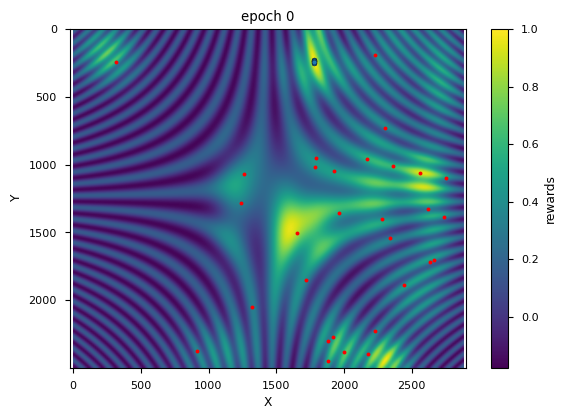

In [92]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

top_k = 30

i = 0
population_reward = generation_reward_list[i]
population = generation_list[i]
top_k_indices = np.argpartition(population_reward, -top_k)[-top_k:]
top_k_indices_2d = np.unravel_index(population[top_k_indices],shape=search_space_2d_shape)
fig, ax = plt.subplots()
im = ax.imshow(search_space_rewards)
ax.scatter(top_k_indices_tuple[1],top_k_indices_tuple[0], s=50, cmap='viridis', edgecolors='black',marker='.')  # Add scatter points
scatter, = ax.plot(top_k_indices_2d[1],top_k_indices_2d[0],'.',marker='.',color="red")  # Add scatter points
fig.colorbar(im, label='rewards',ax=ax)
ax.set_title('epoch {i}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.axis("equal")
# plt.show()

def animate(i):
    population_reward = generation_reward_list[i]
    population = generation_list[i]
    top_k_indices = np.argpartition(population_reward, -top_k)[-top_k:]
    top_k_indices_2d = np.unravel_index(population[top_k_indices],shape=search_space_2d_shape)
    scatter.set_data(top_k_indices_2d[1],top_k_indices_2d[0])  # Update the line data
    ax.set_title(f'epoch {i}')
    i
    return (scatter,)
ani = animation.FuncAnimation(fig, animate, frames=len(generation_list), interval=100, blit=True, repeat_delay=1000)

plt.show()

ani.save(f"mock_ga_progress-population_{population_size}-prob_mutation_{prob_mutation}-prob_crossover_{prob_crossover}-harder.gif", writer='pillow') 

In [17]:
search_space_2d_shapetop_k_indices_2d

(2500, 2880)

In [14]:
population.shape

(100,)

In [38]:
offsprings_unravel[:,mutation_id].shape

(5, 20)

In [35]:
offsprings_unravel[:,0]

array([  4,   2,  11,   1, 111])

In [33]:
np.ravel_multi_index(offsprings_unravel,search_space_shape)

array([1686911,  584755, 4485030, 5155082, 5886854, 6691187, 6595273,
       3493803, 5002730, 4757025, 2902625, 4962289, 6926247, 2751231,
        560949, 1930723, 3501507, 5187976, 3568136, 2887113, 6698728,
       1270179, 6173373, 6891169, 3872447, 5800525, 3460985, 2887083,
       5512771, 1775633,  775444, 4887787,  701931, 5873924, 5557412,
       3642915, 5301462, 2023717, 2922418,   60883,   53888, 4986576,
        619450, 3345405,  131036, 4375518,   54938,  963530, 3678774,
       3137262, 2134319, 4595568, 2948990, 5416234, 2319851, 6251848,
       6597502, 6830992,  566424, 1057702, 6071780, 3450702, 2984402,
       5467398, 4429852, 3906604, 4435147, 5581932, 5911125, 4701432,
       6455061, 2680358, 5183907,    6175, 1931842, 7118332, 6595935,
       1642453, 5572980,  487214, 3866504,  633385, 6852440,  924553,
       6139495, 1091190, 7188894, 5632033, 7153317, 4651596, 5415977,
       4747299,   57538, 3635001, 3353037, 5639486, 6913286, 5506198,
       6493337, 3217

'mock_ga_progress-population_40-prob_mutation_0.2-prob_crossover_0.2.gif'